<a href="https://colab.research.google.com/github/avijayant/MultiLabelTextClassification/blob/master/MultilabelTextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict tags on StackOverflow with linear models

### Data

The following cell will download all data required for this assignment into the folder `week1/data`.

In [0]:
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

In [0]:
! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
setup_google_colab.setup_week1()  
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
# setup_google_colab.setup_project()
# setup_google_colab.setup_honor()

--2020-03-17 04:01:35--  https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1991 (1.9K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.94K  --.-KB/s    in 0s      

2020-03-17 04:01:35 (21.0 MB/s) - ‘setup_google_colab.py’ saved [1991/1991]



### Grading
We will create a grader instance below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to platform only after running submitting function in the last part of this assignment. If you want to make partial submission, you can run that cell any time you want.

In [0]:
from grader import Grader

In [0]:
grader = Grader()

### Text preprocessing

Downloading list of stopwords from nltk

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [0]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [0]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [0]:
train.head()

print(len(train),len(validation),len(test))

100000 30000 20000


As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [0]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

Text preparation function to preprocess our text


In [0]:
import re

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
#Try lemmatization
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE," ",text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE,"",text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    return text

In [0]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [0]:
print(test_text_prepare())

Basic tests are passed.


In [0]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [0]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [0]:
y_train[:3]

array([list(['r']), list(['php', 'mysql']), list(['c#'])], dtype=object)

In [0]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}
for title in X_train:
  words = title.split(' ')
  for word in words:
    words_counts[word]=words_counts.get(word,0)+1

for tags in y_train:
  for tag in tags:
    tags_counts[tag]=tags_counts.get(tag,0)+1




In [0]:
tags_counts['r']

1727

We are assuming that *tags_counts* and *words_counts* are dictionaries like `{'some_word_or_tag': frequency}`. After applying the sorting procedure, results will be look like this: `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]`. The grader gets the results in the following format (two comma-separated strings with line break):

    tag1,tag2,tag3
    word1,word2,word3

Pay attention that in this assignment you should not submit frequencies or some additional information.

In [0]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]
print(most_common_tags)
print(most_common_words)
grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

[('javascript', 19078), ('c#', 19077), ('java', 18661)]
[('using', 8278), ('php', 5614), ('java', 5501)]
Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


In [0]:
#Coding up a bag of words vectorizer
DICT_SIZE = 5000
POPULAR_WORDS = [w[0] for w in sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]]
WORDS_TO_INDEX = dict(zip(POPULAR_WORDS, range(DICT_SIZE)))
INDEX_TO_WORDS = dict([(v,k) for k,v in WORDS_TO_INDEX.items()])
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    text_words = text.split(' ')
    for word in text_words:
      if word in words_to_index:
        result_vector[words_to_index[word]] = result_vector[words_to_index[word]] + 1

    return result_vector

In [0]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [0]:
print(test_my_bag_of_words())

Basic tests are passed.


In [0]:
# now we will transform our training validation and test sets
# we use csr sparse matrices sparse row representaion, row slicing is really fast so we can get each example quickly
# 
from scipy import sparse as sp_sparse
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [0]:
#Another classic approach is to use TFIDF vectorization where we take relative frequency in document and corpus into account
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    tfidf_vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.9, ngram_range=(1,3),token_pattern= '(\S+)', max_features=5000)####### YOUR CODE HERE #######
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)

    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [0]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [0]:
tfidf_vocab['c++']

542

In [0]:
#Since this is a multi label classification(one example can have multiple labels)
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler

In [0]:
def train_scaler(X_train):
  scaler = StandardScaler(with_mean=False)
  scaler.fit(X_train)
  return scaler
def train_classifier(X_train, y_train, classifier_type = 'lr'):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    if classifier_type == 'lr':
      baseClassifier = LogisticRegression(max_iter = 500)
    elif classifier_type == 'svc':
      baseClassifier = SVC()
      scaler = StandardScaler(with_mean=False)
      X_train = scaler.fit_transform(X_train)
    classifier = OneVsRestClassifier(baseClassifier).fit(X_train, y_train)

    return classifier

In [0]:
#use svm classifiers
base_type = 'svc'
scaler_bag = train_scaler(X_train_mybag)
scaler_tfidf = train_scaler(X_train_tfidf)
classifier_mybag = train_classifier(X_train_mybag, y_train,'svc')
classifier_tfidf = train_classifier(X_train_tfidf, y_train,'svc')

In [0]:
if base_type=='svc':
  X_val_mybag = scaler_bag.transform(X_val_mybag)
  X_val_tfidf = scaler_tfidf.transform(X_val_tfidf)

y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [0]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_mybag)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(15,25):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [0]:
def print_evaluation_scores(y_val, predicted):
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    print('Accuracy : {}'.format(accuracy_score(y_val, predicted)))
    print('F1-score : Macro : {} \t Micro : {} \t Weighted : {}'.format(f1_score(y_val, predicted, average='macro'),f1_score(y_val, predicted, average='micro'), f1_score(y_val, predicted, average='weighted')))
    print('Precision : Macro : {} \t Micro : {} \t Weighted : {}'.format(average_precision_score(y_val, predicted, average='macro'),average_precision_score(y_val, predicted, average='micro'), average_precision_score(y_val, predicted, average='weighted')))

In [0]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

In [0]:
from metrics import roc_auc
%matplotlib inline

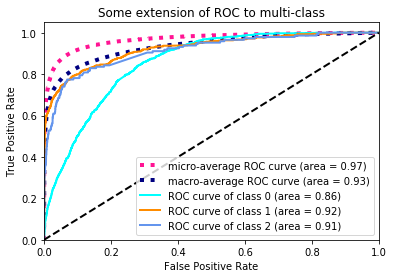

In [0]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

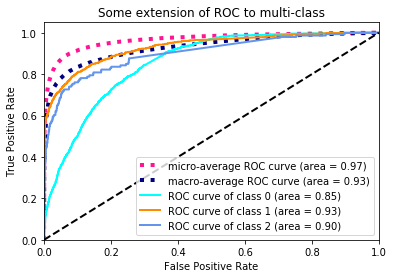

In [0]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

When you are happy with the quality, create predictions for *test* set, which you will submit to Coursera.

In [0]:
test_predictions =  classifier_mybag.predict(X_test_mybag) 
test_pred_inversed = mlb.inverse_transform(test_predictions)
test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))

Current answer for task MultilabelClassification is:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json,web-services
7	java,...


### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

In [0]:
# we will look at the coefficients of our logistic regression for a label to check which are the best positive and negative words for each tag
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator.     
    est = classifier.estimators_[tags_classes.index(tag)]
    top_positive_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][-5:]]  # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][:5]] # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [0]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	kernel, printf, scanf, malloc, c
Top negative words:	php, javascript, objective c, java, python

Tag:	c++
Top positive words:	stdstring, mfc, boost, qt, c++
Top negative words:	php, javascript, java, python, jquery

Tag:	linux
Top positive words:	address, cron, centos, signal, linux
Top negative words:	javascript, c#, jquery, aspnet, array



### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [0]:
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json,web-services
7	java,...


In [0]:
STUDENT_EMAIL = 'avijayant@gmail.com'# EMAIL 
STUDENT_TOKEN = 'SiBkurhJWs4CtkHF'# TOKEN 
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json,web-services
7	java,...


If you want to submit these answers, run cell below

In [0]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
